# 0 load dataset and install packages

In [2]:
from datasets import load_dataset

ds = load_dataset("clarin-knext/fiqa-pl", "corpus")
ds

0000.parquet:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

C:\Users\adam6\PycharmProjects\NlpProject\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adam6\.cache\huggingface\hub\datasets--clarin-knext--fiqa-pl. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Generating corpus split:   0%|          | 0/57638 [00:00<?, ? examples/s]

DatasetDict({
    corpus: Dataset({
        features: ['_id', 'title', 'text'],
        num_rows: 57638
    })
})

In [119]:
ds['corpus']['text'][2137]

'Zawsze jestem podejrzliwy, gdy artykuł wykorzystuje 2 punkty danych, aby zasugerować trend. Listopad 1997 i grudzień 2016. Ok? A co z tymi wszystkimi latami pomiędzy? Rok 1997 mógł mieć niezwykle wysoką liczbę z powodu boomu Dot Com, kiedy wszyscy i ich brat tworzyli strony internetowe o nic nie robili i upubliczniali.'

# 1) Devise two regular expressions:
- extracting times, e.g. recognizing 20:30 as an instance of a time.
- extracting dates, e.g. recognizing 20 września as an instance of a date.

## Preparing regex that captures all dates with text month
First, we will conjugate the names of months by verbal cases

In [83]:
import os
miesiace_odmiana = {
    "styczen": ["Styczeń", "Stycznia", "Styczniowi", "Styczeń", "Styczniem", "Styczniu", "Styczniu"],
    "luty": ["Luty", "Lutego", "Lutemu", "Luty", "Lutym", "Lutym", "Lutym"],
    "marzec": ["Marzec", "Marca", "Marcowi", "Marzec", "Marcem", "Marcu", "Marcu"],
    "kwieciem": ["Kwiecień", "Kwietnia", "Kwietniowi", "Kwiecień", "Kwietniem", "Kwietniu", "Kwietniu"],
    "maj": ["Maj", "Maja", "Majowi", "Maj", "Majem", "Maju", "Maju"],
    "czerwiec": ["Czerwiec", "Czerwca", "Czerwcowi", "Czerwiec", "Czerwcem", "Czerwcu", "Czerwcu"],
    "lipiec": ["Lipiec", "Lipca", "Lipcowi", "Lipiec", "Lipcem", "Lipcu", "Lipcu"],
    "sierpien": ["Sierpień", "Sierpnia", "Sierpniowi", "Sierpień", "Sierpniem", "Sierpniu", "Sierpniu"],
    "wrzesien": ["Wrzesień", "Września", "Wrześniowi", "Wrzesień", "Wrześniem", "Wrześniu", "Wrześniu"],
    "pazdziernik": ["Październik", "Października", "Październikowi", "Październik", "Październikiem", "Październiku", "Październiku"],
    "listopad": ["Listopad", "Listopada", "Listopadowi", "Listopad", "Listopadem", "Listopadzie", "Listopadzie"],
    "grudzien": ["Grudzień", "Grudnia", "Grudniowi", "Grudzień", "Grudniem", "Grudniu", "Grudniu"]
}

for i in miesiace_odmiana:
    print(os.path.commonprefix(miesiace_odmiana[i]),end=" ")

Stycz Lut Mar Kwie Maj Czerw Lip Sierp Wrze Październik Listopad Grud 

In [197]:
import re

example_text_array = ["Listopad 1997","aaaa Listopad 20","listopad 10","10 listopada","listopada 31","30 listopada 1999 kolejna data 1999","1999 listopada 31 kolejna data 1999"]
findall_array = []

#regex_expression = "([Ss]tycz|[Ll]ut|[Mm]ar|[Kk]wie|[Mm]aj|[Cc]zerw|[Ll]ip|[Ss]ierp|[Ww]rze|[Pp]aździernik|[Ll]istopad|[Gg]rud)"
regex_expression_test="[0-9]*.?[Ll]istopad[a-z]*[ąćęłńżź]?\s[0-9]+"

for i in example_text_array:
    result = re.findall(regex_expression_test, i)
    findall_array.append(result)
    
print(findall_array)

[['Listopad 1997'], [' Listopad 20'], ['listopad 10'], [], ['listopada 31'], ['30 listopada 1999'], ['1999 listopada 31']]


In [194]:
regex_date = ("[0-9]*.?([Ss]tycz[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Ll]ut[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Mm]ar[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Kk]wie[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Mm]aj[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Cc]zerw[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Ll]ip[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Ss]ierp[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Ww]rze[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Pp]aździernik[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Ll]istopad[a-z]*[ąćęłńżź]?\s[0-9]+"
              "|[Gg]rud[a-z]*[ąćęłńżź]?\s[0-9]+)")
re.findall(regex_date, ds['corpus']['text'][2137])

['Listopad 1997', 'grudzień 2016']

## Preparing regex that captures time

In [233]:
example_text_array = ["aaa115:30:00 aaa","31:21aaa","aaa21:37aaa","24:34","23:69","25:32"]
findall_array = []

regex_time=("[01][0-9]:[0-5][0-9]:?[0-5]?[0-9]?|"
            "2[0-3]:[0-5][0-9]:?[0-5]?[0-9]?")

for i in example_text_array:
    result = re.findall(regex_time, i)
    findall_array.append(result)
    
print(findall_array)

[['15:30:00'], [], ['21:37'], [], [], []]


# 2) Search for occurrences of times and dates in the dataset.

## Find all dates

In [316]:
output_array_dates = []

for i in ds['corpus']:
    result = re.findall(regex_date, i['text'])
    if result:
        result.append(i['_id'])
        output_array_dates.append(result)
        
output_array_dates[:2]

[['kwietnia 2018', 'kwietnia 2018', '800'],
 ['październikiem 2008',
  'lipcem 2014',
  'mają 65',
  'października 2008',
  'lipca 2014',
  '1941']]

 Although the regex found all the dates where the year or month is after the month, we can find also a few wrong findings. Like one listed below where we found "mają 20" from "Ci, którzy mają 20 000 mil". In case of Maj we could just 
delete the special polish sign from regex but it would not change the output of another example like "Trzymaj 50 000 $" where regex found "maj 50". In that case we could not change the regex cause there could be a date like "maj 5" 
or "maj 585 BCE" which is the date of Battle of the Eclipse https://en.wikipedia.org/wiki/Battle_of_the_Eclipse

In [314]:
def show_text_from_id(id):
    for j in ds['corpus']:
        if j['_id'] == id:
            return j['text']

#print(show_text_from_id('359131'))
#print("===================================================")
#print(show_text_from_id('585494'))

## Find all times

In [313]:
output_array_times = []

for i in ds['corpus']:
    result = re.findall(regex_time, i['text'])
    if result:
        result.append(i['_id'])
        output_array_times.append(result)
        
output_array_times[:5]

[['17:57:23', '17:57:23', '628'],
 ['20:00', '17:00', '1926'],
 ['22:00', '2221'],
 ['12:00', '2854'],
 ['17:30:33', '6760']]

In case of time there is no additional data that can match the regex only numbers.

# 3) Plot results from point 2:
- for times create a bar plot for full hours.
- for dates create a bar plot for months.

## Creating plot for hours

In [249]:
dict_to_plot_time = {f"{i:02}": 0 for i in range(24)} 

for i in output_array_times:
    for j in range(len(i)-1):
        dict_to_plot_time[i[j][:2]] += 1
dict_to_plot_time

{'00': 8,
 '01': 8,
 '02': 18,
 '03': 6,
 '04': 9,
 '05': 4,
 '06': 10,
 '07': 1,
 '08': 4,
 '09': 8,
 '10': 8,
 '11': 16,
 '12': 14,
 '13': 17,
 '14': 16,
 '15': 27,
 '16': 27,
 '17': 35,
 '18': 16,
 '19': 19,
 '20': 18,
 '21': 8,
 '22': 19,
 '23': 15}

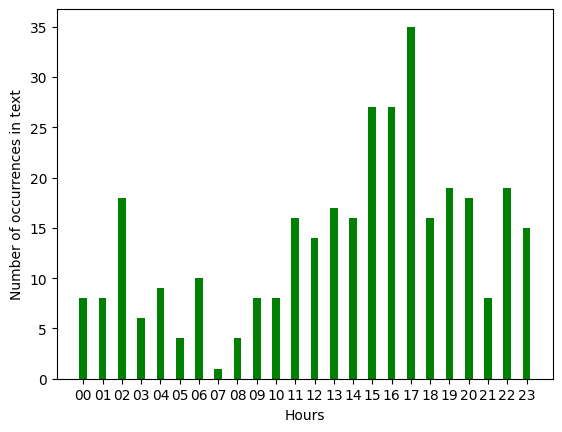

In [250]:
import matplotlib.pyplot as plt

plt.bar(dict_to_plot_time.keys(), dict_to_plot_time.values(), color ='green', 
        width = 0.4)

plt.xlabel("Hours")
plt.ylabel("Number of occurrences in text")
plt.show()

## Creating plot for months

In [256]:
dict_to_plot_months = {
    "Styczeń": 0,
    "Luty": 0,
    "Marzec": 0,
    "Kwiecień": 0,
    "Maj": 0,
    "Czerwiec": 0,
    "Lipiec": 0,
    "Sierpień": 0,
    "Wrzesień": 0,
    "Październik": 0,
    "Listopad": 0,
    "Grudzień": 0
}

#Stycz Lut Mar Kwie Maj Czerw Lip Sierp Wrze Październik Listopad Grud
for i in output_array_dates:
    for j in range(len(i)-1):
        if re.match("[Ss]tycz[a-z]*",i[j]):
            dict_to_plot_months['Styczeń'] += 1
        if re.match("[Ll]ut[a-z]*",i[j]):
            dict_to_plot_months['Luty'] += 1
        if re.match("[Mm]ar[a-z]*",i[j]):
            dict_to_plot_months['Marzec'] += 1
        if re.match("[Kk]wie[a-z]*",i[j]):
            dict_to_plot_months['Kwiecień'] += 1
        if re.match("[Mm]aj[a-z]*",i[j]):
            dict_to_plot_months['Maj'] += 1
        if re.match("[Cc]zerw[a-z]*",i[j]):
            dict_to_plot_months['Czerwiec'] += 1
        if re.match("[Ll]ip[a-z]*",i[j]):
            dict_to_plot_months['Lipiec'] += 1
        if re.match("[Ss]ierp[a-z]*",i[j]):
            dict_to_plot_months['Sierpień'] += 1
        if re.match("[Ww]rze[a-z]*",i[j]):
            dict_to_plot_months['Wrzesień'] += 1
        if re.match("[Pp]aździernik[a-z]*",i[j]):
            dict_to_plot_months['Październik'] += 1
        if re.match("[Ll]istopad[a-z]*",i[j]):
            dict_to_plot_months['Listopad'] += 1
        if re.match("[Gg]rud[a-z]*",i[j]):
            dict_to_plot_months['Grudzień'] += 1

dict_to_plot_months

{'Styczeń': 208,
 'Luty': 78,
 'Marzec': 154,
 'Kwiecień': 116,
 'Maj': 224,
 'Czerwiec': 106,
 'Lipiec': 112,
 'Sierpień': 106,
 'Wrzesień': 6,
 'Październik': 87,
 'Listopad': 81,
 'Grudzień': 139}

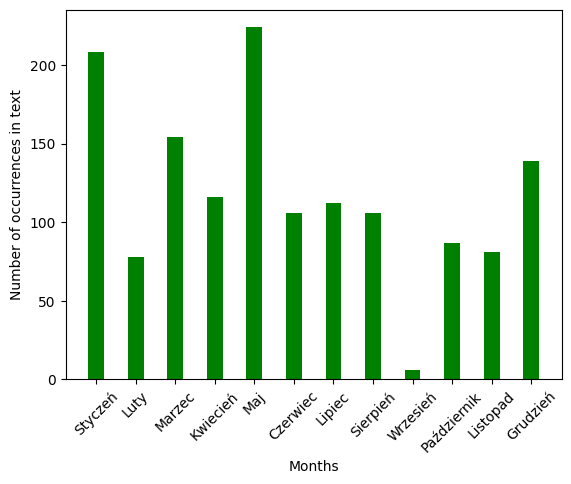

In [260]:
plt.bar(dict_to_plot_months.keys(), dict_to_plot_months.values(), color ='green', 
        width = 0.4)

plt.xticks(rotation=45)
plt.xlabel("Months")
plt.ylabel("Number of occurrences in text")
plt.show()

# 4) Compute the number of occurrences of kwiecień word in any inflectional form. Use a compact form for the query (i.e. joining all forms of the word by alternative is forbidden).

We can use the regex i prepared before, also to remember the inflectional form is below
"Kwiecień", "Kwietnia", "Kwietniowi", "Kwiecień", "Kwietniem", "Kwietniu", "Kwietniu"

In [312]:
regex_april = "[Kk]wie[a-z]*[ń]?"
output_array_april = []

for i in ds['corpus']:
    result = re.findall(regex_april, i['text'])
    if result:
        result.append(i['_id'])
        output_array_april.append(result)
output_array_april[:5]

[['kwietnia', 'kwietnia', '800'],
 ['kwietnia', 'kwietnia', 'kwietnia', 'kwietnia', '2035'],
 ['kwietniu', '2653'],
 ['kwietniu', '3717'],
 ['kwietniu', 'kwietniowym', '4845']]

# 5) As in 4, but preceded by a number and a space.

In [311]:
regex_april_number = "[0-9]\s[Kk]wie[a-z]*[ń]?"
output_array_april_number = []

for i in ds['corpus']:
    result = re.findall(regex_april_number, i['text'])
    if result:
        result.append(i['_id'])
        output_array_april_number.append(result)
output_array_april_number[:5]

[['2 kwietnia', '0 kwietnia', '800'],
 ['6 kwietnia', '5 kwietnia', '5 kwietnia', '4 kwietnia', '2035'],
 ['5 kwietnia', '5 kwietnia', '8018'],
 ['5 kwietnia', '21910'],
 ['0 kwietnia', '27037']]

# 6) As in 4, but not preceded by a number and a space. Check if the results from 5 and 6 sum to 4

In [310]:
regex_april_no_number = "(?<![0-9]\s)[Kk]wie[a-z]*[ń]?"
output_array_april_no_number = []

for i in ds['corpus']:
    result = re.findall(regex_april_no_number, i['text'])
    if result:
        result.append(i['_id'])
        output_array_april_no_number.append(result)
output_array_april_no_number[:5]

[['kwietniu', '2653'],
 ['kwietniu', '3717'],
 ['kwietniu', 'kwietniowym', '4845'],
 ['kwietniu', '7925'],
 ['kwietniu', '14286']]

In [289]:
print(len(output_array_april_number)+len(output_array_april_no_number)==len(output_array_april))
print("Length of array with april preceded by number and space",len(output_array_april_number))
print("Length of array with april NOT preceded by number and space",len(output_array_april_no_number))
print("Length of array with april",len(output_array_april))

False
Length of array with april preceded by number and space 139
Length of array with april NOT preceded by number and space 149
Length of array with april 277


In [288]:
ids_no_number = {sublist[-1] for sublist in output_array_april_no_number}
ids_number = {sublist[-1] for sublist in output_array_april_number}

common_ids = ids_no_number.intersection(ids_number)

print("Common ID:", common_ids)

Common ID: {'577475', '536849', '406623', '550661', '292602', '521552', '470101', '107727', '180461', '338170', '420529'}


As we can see we are doubling a few texts, if we would subtract the length of common_ids from sum of output_array_april_number and output_array_april_no_number we woould get 139+149-11=277

In [302]:
print(show_text_from_id('577475'))


Krótko mówiąc, proponuję spojrzeć na formularz W-4 i odpowiednio go dostosować. I tak, możesz ubiegać się o siebie jako na utrzymaniu, chyba że ktoś inny twierdzi, że jesteś osobą na utrzymaniu. Ale oto bardziej szczegółowe wyjaśnienie, jak to działa. Jak działa podatek dochodowy. Podczas gdy większość ludzi myśli tylko o systemie podatkowym i urzędzie skarbowym (IRS) w miarę zbliżania się kwietnia, w rzeczywistości jest to niekończący się proces. Dla naszych celów dobrym sposobem na wyjaśnienie, jak działa system, jest podanie przykładu jednego Amerykanina zarabiającego, nazwiemy go Joe. Proces podatkowy rozpoczyna się, gdy Joe rozpoczyna nową pracę. On i jego pracodawca uzgadniają jego wynagrodzenie, które zostanie wliczone w jego dochód brutto na koniec roku. Jedną z pierwszych rzeczy, które musi zrobić po zatrudnieniu, jest wypełnienie wszystkich formularzy podatkowych, w tym formularza W-4. Formularz W-4 zawiera wszystkie informacje dotyczące zasiłku dla Joe'go, takie jak liczba o

As we can see in the text there are two instances of april "15 kwietnia" and "kwietnia"

# 7) Ask an LLM (e.g. Bielik) to complete these tasks for you. Compare and criticize the code generated by the LLM

## Prompt

### Date task
wygeneruj w pythonie regex który potrafi znaleźć w tekście daty tak jak w przykładzie. 20 październik, listopad 2012, luty 21, maj 16, styczeń 21, czerwiec 10, sierpień 1999, 10 września 2019. Pamiętaj o tym że każdy miesiąc może być różnie odmieniony

### Time task
teraz napisz regex w pythonie który znajdzie czas w tekscie taki jak 00:21, 21:37, 15:14

## Bielik

Bielik answer for date task, after instructing him about inflectional form of words he went dumb an copy pasted styczniem. I think i do not need to tell that it will not work :D

In [ ]:
date_pattern = r"(?:stycznia|styczniu|stycznia|styczniu|styczniowi|styczniu|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|styczniem|"

Bielik answer for time task. This regex looks good, Bielik considerd the cases where time could be 24:60 or 00:60, although not the best cause 0[0-9]|1[0-9] could be merged to [0-1][0-9]

In [304]:
# Wzorzec regex dla formatu czasu HH:MM
time_pattern = r"\b(?:0[0-9]|1[0-9]|2[0-3]):[0-5][0-9]\b"

# Przykładowe teksty do przetestowania
texts = [
    "Spotkanie jest o 00:21.",
    "Film zaczyna się o 21:37.",
    "Autobus odjeżdża o 15:14.",
    "Niepoprawny format: 24:60",
    "Niepoprawny format: 25:30",
    "Niepoprawny format: 00:60",
    "Niepoprawny format: 00:70",
    "Poprawny format: 23:59",
]

# Testowanie wzorca na przykładowych tekstach
for text in texts:
    print(f"Tekst: {text}")
    print(f"Znalezione czasy: {re.findall(time_pattern, text)}")
    print()


Tekst: Spotkanie jest o 00:21.
Znalezione czasy: ['00:21']

Tekst: Film zaczyna się o 21:37.
Znalezione czasy: ['21:37']

Tekst: Autobus odjeżdża o 15:14.
Znalezione czasy: ['15:14']

Tekst: Niepoprawny format: 24:60
Znalezione czasy: []

Tekst: Niepoprawny format: 25:30
Znalezione czasy: []

Tekst: Niepoprawny format: 00:60
Znalezione czasy: []

Tekst: Niepoprawny format: 00:70
Znalezione czasy: []

Tekst: Poprawny format: 23:59
Znalezione czasy: ['23:59']


## Chat gpt

Date task. Chat gpt handled task very well it was able to generate the pattern and test cases that matched the date format mentioned in prompt. While it seems that the chat accounted for all possible scenarios, that is not the case.
Let us consider this date "czerwcu 2015". We can say "Grałem w wiedźmina w czerwcu 2015" which is a proper polish sentence and proper date the code provided by chat would not find it.

In [308]:
import re

# Lista miesięcy w różnych odmienionych formach
months = [
    "styczeń", "stycznia", "luty", "lutego", "marzec", "marca",
    "kwiecień", "kwietnia", "maj", "maja", "czerwiec", "czerwca",
    "lipiec", "lipca", "sierpień", "sierpnia", "wrzesień", "września",
    "październik", "października", "listopad", "listopada", "grudzień", "grudnia"
]

# Tworzenie regex na podstawie miesięcy
months_pattern = '|'.join(months)

# Regex do znajdowania dat
date_pattern = rf"(\b(\d{{1,2}} )?({months_pattern}) (\d{{4}}|\d{{2}})?\b|\b({months_pattern}) (\d{{1,2}})\b)"

# Testowy tekst
text = "20 październik, listopad 2012, luty 21, maj 16, styczeń 21, czerwiec 10, sierpień 1999, 10 września 2019."

# Znajdowanie dat
matches = re.findall(date_pattern, text)

# Wyodrębnianie wyników
found_dates = [match[0] for match in matches]
print(found_dates)


['listopad 2012', 'luty 21', 'maj 16', 'styczeń 21', 'czerwiec 10', 'sierpień 1999', '10 września 2019']


Time task. Again chat gpt handled task well. He considered all possible test cases for date format.

In [309]:
import re

# Regex do znajdowania czasu w formacie HH:MM
time_pattern = r"\b([01]?\d|2[0-3]):([0-5]\d)\b"

# Testowy tekst
text = "Spotkanie rozpoczyna się o 00:21, a drugie o 21:37. Mamy też przerwę o 15:14. 00:60, 25:25"

# Znajdowanie czasów
matches = re.findall(time_pattern, text)

# Wyodrębnianie wyników
found_times = [match[0] + ':' + match[1] for match in matches]
print(found_times)


['00:21', '21:37', '15:14']


# 8) Answering questions

## a) Are regular expressions good at capturing times?
Yes and no. While times in this task had a considered schema where the matched text should be 2 digits colon 2 digits in language we can consider more schemes, like "dwudziesta pierwsza trzydzieści siedem" which would be hard to match with regex expression. Also about task schema for time we can consider this example, 21:25. It could be a time but also it could be a match result in volleyball, so considering that not all times we matched could be time in text   

## b) Are regular expressions good at capturing dates
No. Considering the text variation of date like "20 maja 2012". In polish every world has multiple inflectional form so it is hard to macth that form while trying not to match another words like "Obiekt badań Maja 2012"

## c) How one can be sure that the expression has matched all and only the correct expressions of a given type?
To bes sure of that we should consider all border cases of our worlds, like inflectional form of the world Maj, Maja, Majowy but even with that we cannot be sure about all positive outcomes. Given the times considering the time format is easier cause there is no inflectional form just numbers. 

## d) Is LLM able to generate regular expressions?

For simple task as time bielik was pretty good, but while considering more complex case the date task, bielik could not handle the inflectional form of polsih words unlike the chat gpt. Overall LLM can be a good start of regex expression that later could be optimized by programmer